<a href="https://colab.research.google.com/github/gomezc08/Enhancing-Image-Classification-with-Dynamic-Test-Time-Training-TTT-/blob/main/TTT_on_an_Image_Transformation_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhancing Image Classification Using Test-Time-Training (TTT)

1.   Chris Gomez (G23406427)  

# 0. Initialization

### a. Import necessary Libraries

In [ ]:
# Pytorch.
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# evaluation metrics.
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# torchvision.
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset

# images.
from PIL import Image, ImageFilter, ImageEnhance

# kaggle.
import kagglehub

# plots.
import matplotlib.pyplot as plt
import seaborn as sns

# standard libraries.
import os
import numpy as np
import random
import shutil

# 1. Preprocess Data

### a. Define training and testing datasets

In [ ]:
# https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
path = kagglehub.dataset_download("borhanitrash/animal-image-classification-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-classification-dataset


In [ ]:
print(os.listdir(path + "/Animals"))

['snakes', 'dogs', 'cats']


In [ ]:
"""folder_path = os.path.join(path, "Animals", "train")
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Removed: {folder_path}")
else:
    print("Folder not found")"""

'folder_path = os.path.join(path, "Animals", "train")\nif os.path.exists(folder_path):\n    shutil.rmtree(folder_path)\n    print(f"Removed: {folder_path}")\nelse:\n    print("Folder not found")'

In [ ]:
"""folder_path = os.path.join(path, "Animals", "test")
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Removed: {folder_path}")
else:
    print("Folder not found")"""

'folder_path = os.path.join(path, "Animals", "test")\nif os.path.exists(folder_path):\n    shutil.rmtree(folder_path)\n    print(f"Removed: {folder_path}")\nelse:\n    print("Folder not found")'

In [ ]:
dataset = datasets.ImageFolder(root = path + "/Animals")

In [ ]:
print(os.listdir(path + "/Animals"))

['snakes', 'dogs', 'cats']


In [ ]:
class MultiTransformWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None, apply_transforms=True, num_rotation_classes=8):
        self.dataset = dataset
        self.base_transform = transform
        self.apply_transforms = apply_transforms
        self.num_rotation_classes = num_rotation_classes

        # Calculate rotation angles based on number of classes
        self.rotation_angles = [i * (360.0 / num_rotation_classes) for i in range(num_rotation_classes)]

        # Define other transformations
        self.blur_levels = [0, 1, 2, 3]  # None, Light, Medium, Heavy
        self.brightness_levels = [0.7, 0.85, 1.0, 1.15]  # Darker to Brighter

        # Create mapping of transform values to labels
        self.rotation_map = {angle: i for i, angle in enumerate(self.rotation_angles)}
        self.blur_map = {level: i for i, level in enumerate(self.blur_levels)}
        self.brightness_map = {level: i for i, level in enumerate(self.brightness_levels)}

    def __getitem__(self, index):
        image, class_label = self.dataset[index]

        if self.base_transform:
            image = self.base_transform(image)

        # Default transform labels
        transform_labels = {
            'rotation': 0,  # Default: no rotation
            'blur': 0,      # Default: no blur
            'brightness': 2  # Default: normal brightness (index 2 = 1.0)
        }

        if self.apply_transforms:
            # Pick a random transformation type!
            transform_type = random.choice(['rotation', 'blur', 'brightness'])

            if transform_type == 'rotation':
                angle = random.choice(self.rotation_angles)
                transform_labels['rotation'] = self.rotation_map[angle]
                image = TF.rotate(image, angle)

            elif transform_type == 'blur':
                blur_level = random.choice(self.blur_levels)
                transform_labels['blur'] = self.blur_map[blur_level]

                if blur_level > 0:  # Apply Gaussian blur with different kernel sizes
                    kernel_size = 2 * blur_level + 1  # 3, 5, or 7
                    image = TF.gaussian_blur(image, kernel_size)

            elif transform_type == 'brightness':
                brightness = random.choice(self.brightness_levels)
                transform_labels['brightness'] = self.brightness_map[brightness]
                image = TF.adjust_brightness(image, brightness)

        return image, class_label, transform_labels

    def __len__(self):
        return len(self.dataset)

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_subset, test_subset = random_split(dataset, [train_size, test_size])

# Apply transformations to each subset
train_dataset_wrapped = MultiTransformWrapper(train_subset, transform=train_transforms)
test_dataset_wrapped = MultiTransformWrapper(test_subset, transform=test_transforms)

In [ ]:
print(f"Train dataset size: {len(train_dataset_wrapped)}")
print(f"Test dataset size: {len(test_dataset_wrapped)}")

Train dataset size: 2400
Test dataset size: 600


In [ ]:
train_loader = DataLoader(train_dataset_wrapped,
                          batch_size=32,
                          shuffle=True,
                          worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id))

test_loader = DataLoader(test_dataset_wrapped,
                         batch_size=32,
                         shuffle=False)

### b. Grab Shape of Images

In [ ]:
IMAGE_SHAPE = tuple(train_dataset_wrapped[0][0].shape)    # should be (3, 224, 224); refer to the code block above!
print("Image size: " + str(IMAGE_SHAPE))

Image size: (3, 224, 224)


### c. Visualizing *some*  Training and Testing Images

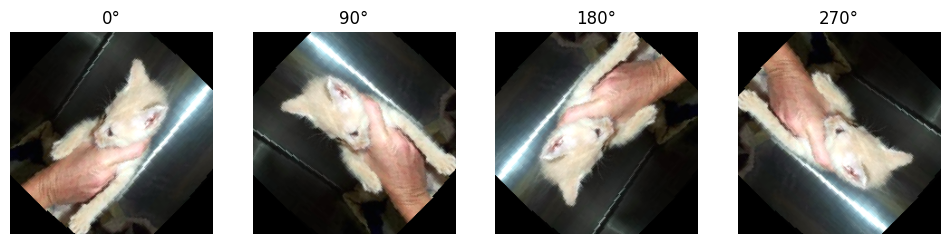

In [ ]:
data_iter = iter(train_loader)
images, labels, _ = next(data_iter)

image_tensor = images[4].cpu()
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for j, angle in enumerate([0, 90, 180, 270]):
    img = TF.rotate(image_tensor, angle)
    axs[j].imshow(img.permute(1, 2, 0))
    axs[j].set_title(f"{angle}°")
    axs[j].axis("off")
plt.show()

# 2. CNN Network

### a. Define CNN Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self, seed=42, num_rotation_classes=8):
        super(CNN, self).__init__()
        # Seed and device setup
        self.seed = torch.manual_seed(seed)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Number of rotation angles to classify
        self.num_rotation_classes = num_rotation_classes

        # CNN (same as before in the prev notebook)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4)
        self.max1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.max2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.max4 = nn.MaxPool2d(kernel_size=2)

        # Shared feature layers
        self.fc1 = nn.Linear(in_features=128 * 12 * 12, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)

        # Classification head
        self.fc3 = nn.Linear(in_features=128, out_features=3)  # Animal classes

        # Transformation prediction heads: new output neurons in addition to the animla classes one.
        self.fc_rotation = nn.Linear(in_features=128, out_features=num_rotation_classes)
        self.fc_blur = nn.Linear(in_features=128, out_features=4)  # Different blur levels
        self.fc_brightness = nn.Linear(in_features=128, out_features=4)  # Different brightness levels

        self.to(self.device)

    def forward(self, state):
        # Feature extraction
        x = self.max1(F.relu(self.conv1(state)))
        x = self.max2(F.relu(self.conv2(x)))
        x = self.max3(F.relu(self.conv3(x)))
        x = self.max4(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)

        # Shared features
        x = F.relu(self.fc1(x))
        features = F.relu(self.fc2(x))

        # Output all heads
        class_output = self.fc3(features)
        rotation_output = self.fc_rotation(features)
        blur_output = self.fc_blur(features)
        brightness_output = self.fc_brightness(features)

        # we now have 4 returns/outputs: class and prediction of image stuff!
        return class_output, {
            'rotation': rotation_output,
            'blur': blur_output,
            'brightness': brightness_output
        }

### b. Initialize Model

In [ ]:
model_cnn = CNN()

### c. Define Hyperparameters for Training

In [ ]:
total_epochs = 10
loss = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model_cnn.parameters(), lr = learning_rate)

### d. Training

In [ ]:
def train(model, train_loader, criterion, optimizer, epochs, verbose=False):
    model.train()  # Sets model to training mode
    for epoch in range(1, epochs+1):
        running_loss = 0.0
        for animal_image, animal_label, transform_labels in train_loader:
            # Move data to device
            animal_image = animal_image.to(model.device)
            animal_label = animal_label.to(model.device)

            # Convert transform_labels to appropriate format if it's a dictionary
            if isinstance(transform_labels, dict):
                for transform_type in transform_labels:
                    transform_labels[transform_type] = transform_labels[transform_type].to(model.device)
            else:
                # If it's still the old format (just rotation labels)
                rotation_label = transform_labels.to(model.device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            class_output, transform_outputs = model(animal_image)

            # Calculate losses
            loss_cls = criterion(class_output, animal_label)

            # Handle different transformation outputs
            transform_loss = 0
            if isinstance(transform_labels, dict) and isinstance(transform_outputs, dict):
                # For multi-transformation model
                for transform_type in transform_outputs:
                    if transform_type in transform_labels:
                        transform_loss += criterion(transform_outputs[transform_type], transform_labels[transform_type])
            else:
                # For old model with just rotation
                transform_loss = criterion(transform_outputs, rotation_label)

            # Combine losses
            loss = loss_cls + transform_loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print epoch results
        print(f"Epoch [{epoch}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Optional verbose output
        if verbose and epoch % 5 == 0:
            print(f"  Class Loss: {loss_cls.item():.4f}, Transform Loss: {transform_loss.item():.4f}")

In [ ]:
train(model_cnn, train_loader, loss, optimizer, epochs=total_epochs, verbose=True)

Epoch [1/10], Loss: 4.0799
Epoch [2/10], Loss: 3.5145
Epoch [3/10], Loss: 3.1721
Epoch [4/10], Loss: 2.9193
Epoch [5/10], Loss: 2.6564
  Class Loss: 0.5575, Transform Loss: 1.8796
Epoch [6/10], Loss: 2.5550
Epoch [7/10], Loss: 2.4989
Epoch [8/10], Loss: 2.3901
Epoch [9/10], Loss: 2.3398
Epoch [10/10], Loss: 2.3693
  Class Loss: 0.6315, Transform Loss: 1.5312


### e. Saving model

In [ ]:
torch.save(model_cnn.state_dict(), "cnn_weights.pth")

# 3. Testing

### a. load model

In [ ]:
model_cnn = CNN()  # changed to load weights into the model
model_cnn.load_state_dict(torch.load("cnn_weights.pth"))
model_cnn.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (max3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (fc_rotation): Linear(in_features=128, out_features=8, bias=True)
  (fc_blur): Linear(in_features=128, out_features=4, bias=True)
  (fc_brightness): Linear(in_features=128, out_features=4, bias=True)
)

### b. Testing w/o TTT

In [ ]:
def test(model):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch in test_loader:
            if len(batch) == 3:
                images, labels, _ = batch  # If batch contains transformation labels
            elif len(batch) == 2:
                images, labels = batch  # If batch only has images and labels
            else:
                raise ValueError(f"Unexpected batch format: {batch}")

            # Move images and labels to the device
            images, labels = images.to(model.device), labels.to(model.device)

            # Forward pass
            outputs, _ = model(images)  # Ignore the transformation outputs
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append true and predicted labels to lists
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy w/o TTT: {accuracy:.2f}%')
    return all_labels, all_predictions, accuracy

In [ ]:
all_labels, all_predictions, base_accuracy = test(model_cnn)

Accuracy w/o TTT: 65.17%


### c. Testing w/ TTT

In [ ]:
def test_ttt_combined(model, ttt_epochs=5, lr=0.001):
    model.eval()
    total = 0
    correct = 0
    all_labels = []
    all_preds = []

    # Define multiple transformations
    transformations = [
        ('rotation', [0, 45, 90, 135, 180, 225, 270, 315]),
        ('blur', [0, 1, 2, 3]),  # 0=none, 1-3=increasing blur levels
        ('brightness', [0.7, 0.85, 1.0, 1.15])
    ]

    # Process test images
    for images, class_labels, _ in test_loader:
        images = images.to(model.device)
        class_labels = class_labels.to(model.device)

        with torch.no_grad():
            class_logits, _ = model(images)
            _, original_preds = torch.max(class_logits, 1)

        for i in range(len(images)):
            total += 1

            if original_preds[i] == class_labels[i]:
                correct += 1
                all_labels.append(class_labels[i].item())
                all_preds.append(original_preds[i].item())
                continue

            # Create training set with multiple transformation types
            image_tensor = images[i].cpu()
            transformed_images = []
            transform_labels = {}  # Dictionary to hold labels for each transformation type

            # Initialize transform label lists
            for transform_type, _ in transformations:
                transform_labels[transform_type] = []

            # Apply each type of transformation
            for transform_type, values in transformations:
                for idx, val in enumerate(values):
                    transformed = image_tensor.clone()

                    # Apply the specific transformation
                    if transform_type == 'rotation':
                        transformed = TF.rotate(transformed, val)
                    elif transform_type == 'blur':
                        if val > 0:  # Skip if no blur
                            kernel_size = 2 * val + 1
                            transformed = TF.gaussian_blur(transformed, kernel_size)
                    elif transform_type == 'brightness':
                        transformed = TF.adjust_brightness(transformed, val)

                    transformed_images.append(transformed.unsqueeze(0))

                    # Record transformation label
                    for t_type, _ in transformations:
                        if t_type == transform_type:
                            transform_labels[t_type].append(idx)
                        else:
                            transform_labels[t_type].append(-1)  # -1 means "not this type of transformation"

            # Create tensor dataset for training
            train_images = torch.cat(transformed_images).to(model.device)
            train_transform_labels = {
                t_type: torch.tensor([l for l in labels if l >= 0], dtype=torch.long).to(model.device)
                for t_type, labels in transform_labels.items()
            }

            # Create indices to know which images have which transformation types
            transform_indices = {
                t_type: torch.tensor([i for i, l in enumerate(labels) if l >= 0]).to(model.device)
                for t_type, labels in transform_labels.items()
            }

            # Clone model for this test instance
            model_instance = CNN(num_rotation_classes=len(transformations[0][1]))
            model_instance.load_state_dict(model.state_dict())
            model_instance.to(model.device)

            # Setup optimizer
            optimizer = optim.Adam(model_instance.parameters(), lr=lr)

            # Train on all transformations
            model_instance.train()
            for epoch in range(ttt_epochs):
                optimizer.zero_grad()
                _, transform_outputs = model_instance(train_images)

                # Compute loss for each transformation type
                loss = 0
                for t_type in transform_labels.keys():
                    if len(transform_indices[t_type]) > 0:
                        t_outputs = transform_outputs[t_type][transform_indices[t_type]]
                        t_labels = train_transform_labels[t_type]
                        t_loss = F.cross_entropy(t_outputs, t_labels)
                        loss += t_loss

                loss.backward()
                optimizer.step()

            # Evaluate on original image
            model_instance.eval()
            with torch.no_grad():
                class_logits, _ = model_instance(images[i].unsqueeze(0))
                _, updated_pred = torch.max(class_logits, 1)

            if updated_pred.item() == class_labels[i].item():
                correct += 1
            all_labels.append(class_labels[i].item())
            all_preds.append(updated_pred.item())

    accuracy = 100 * sum([l == p for l, p in zip(all_labels, all_preds)]) / len(all_labels)
    print(f"Final Combined TTT Accuracy: {accuracy:.2f}%")
    return all_labels, all_preds

In [ ]:
labels_ttt, preds_ttt = test_ttt_combined(model_cnn)

Final Combined TTT Accuracy: 71.33%


In [ ]:
def test_ttt_combined_false_labels(model, ttt_epochs=5, lr=0.001):
    model.eval()
    total = 0
    correct = 0
    all_labels = []
    all_preds = []

    transformations = [
        ('rotation', [0, 45, 90, 135, 180, 225, 270, 315]),
        ('blur', [0, 1, 2, 3]),  # 0=none, 1-3=more blur
        ('brightness', [0.7, 0.85, 1.0, 1.15])
    ]

    for images, class_labels, _ in test_loader:
        images = images.to(model.device)
        class_labels = class_labels.to(model.device)

        with torch.no_grad():
            class_logits, _ = model(images)
            _, original_preds = torch.max(class_logits, 1)

        for i in range(len(images)):
            total += 1

            image_tensor = images[i].cpu()
            true_label = class_labels[i].item()

            transformed_images = []
            transform_labels = {t_type: [] for t_type, _ in transformations}

            for transform_type, values in transformations:
                for idx, val in enumerate(values):
                    transformed = image_tensor.clone()

                    if transform_type == 'rotation':
                        transformed = TF.rotate(transformed, val)
                    elif transform_type == 'blur' and val > 0:
                        transformed = TF.gaussian_blur(transformed, 2 * val + 1)
                    elif transform_type == 'brightness':
                        transformed = TF.adjust_brightness(transformed, val)

                    transformed_images.append(transformed.unsqueeze(0))

                    for t_type, _ in transformations:
                        if t_type == transform_type:
                            transform_labels[t_type].append(idx)
                        else:
                            transform_labels[t_type].append(-1)

            train_images = torch.cat(transformed_images).to(model.device)

            # Create false labels: shuffle each transformation label independently
            false_transform_labels = {
                t_type: torch.tensor(
                    random.sample([l for l in labels if l >= 0], len([l for l in labels if l >= 0])),
                    dtype=torch.long
                ).to(model.device)
                for t_type, labels in transform_labels.items()
            }

            transform_indices = {
                t_type: torch.tensor([i for i, l in enumerate(labels) if l >= 0]).to(model.device)
                for t_type, labels in transform_labels.items()
            }

            # Clone model
            model_instance = CNN(num_rotation_classes=len(transformations[0][1]))
            model_instance.load_state_dict(model.state_dict())
            model_instance.to(model.device)

            optimizer = optim.Adam(model_instance.parameters(), lr=lr)
            model_instance.train()

            for epoch in range(ttt_epochs):
                optimizer.zero_grad()
                _, transform_outputs = model_instance(train_images)

                loss = 0
                for t_type in transform_labels.keys():
                    if len(transform_indices[t_type]) > 0:
                        t_outputs = transform_outputs[t_type][transform_indices[t_type]]
                        t_labels = false_transform_labels[t_type]
                        t_loss = F.cross_entropy(t_outputs, t_labels)
                        loss += t_loss

                loss.backward()
                optimizer.step()

            # Evaluate classification again
            model_instance.eval()
            with torch.no_grad():
                class_logits, _ = model_instance(images[i].unsqueeze(0))
                _, updated_pred = torch.max(class_logits, 1)

            if updated_pred.item() == true_label:
                correct += 1
            all_labels.append(true_label)
            all_preds.append(updated_pred.item())

    accuracy = 100 * correct / total
    print(f"Final Accuracy w/ FALSE TTT (Combined): {accuracy:.2f}%")
    return all_labels, all_preds

In [ ]:
false_labels, false_preds = test_ttt_combined_false_labels(model_cnn)

Final Accuracy w/ FALSE TTT (Combined): 42.17%


# 4. CNN Evaluation

### a. Confusion Matrix

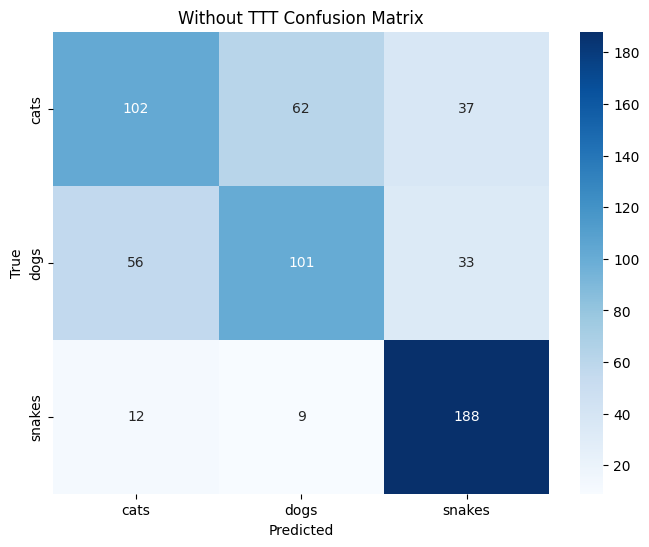

In [ ]:
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Without TTT Confusion Matrix')
plt.show()

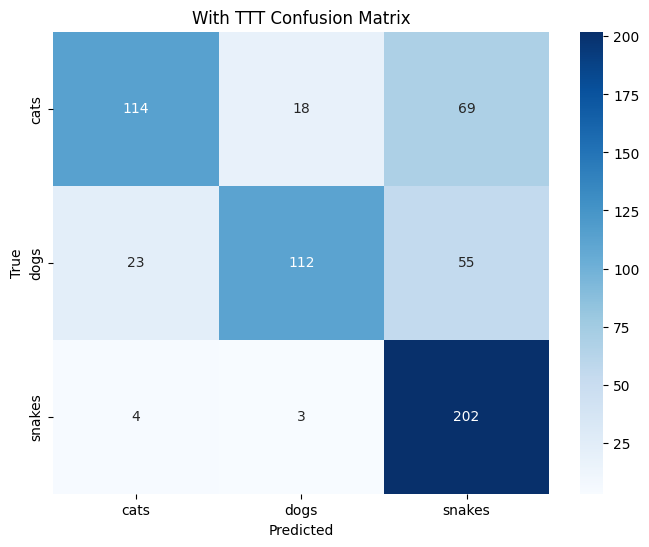

In [ ]:
cm = confusion_matrix(labels_ttt, preds_ttt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('With TTT Confusion Matrix')
plt.show()

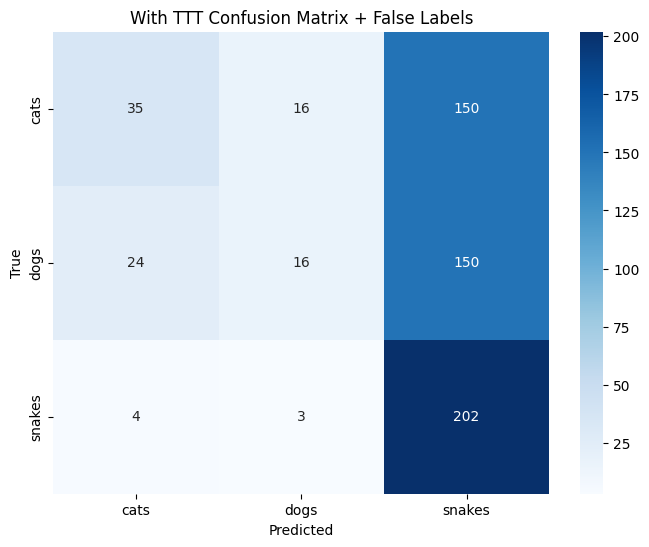

In [ ]:
cm = confusion_matrix(false_labels, false_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('With TTT Confusion Matrix + False Labels')
plt.show()

### b. Recall

In [ ]:
recall = recall_score(all_labels, all_predictions, average='macro')
print(f"Without TTT Recall: {recall}")

Without TTT Recall: 0.6461877216786879


In [ ]:
recall_ttt = recall_score(labels_ttt, preds_ttt, average='macro')
print(f"TTT Recall: {recall_ttt}")

TTT Recall: 0.7077150134494988


In [ ]:
recall_ttt = recall_score(false_labels, false_preds, average='macro')
print(f"TTT Recall with False labels: {recall_ttt}")

TTT Recall with False labels: 0.4082823521943711


### c. Precision

In [ ]:
precision = precision_score(all_labels, all_predictions, average='macro')
print(f"Without TTT Precision: {precision}")

Without TTT Precision: 0.6386304909560724


In [ ]:
precision_ttt = precision_score(labels_ttt, preds_ttt, average='macro')
print(f"TTT Precision: {precision_ttt}")

TTT Precision: 0.7567492677654193


In [ ]:
precision_ttt = precision_score(false_labels, false_preds, average='macro')
print(f"TTT Precision with False labels: {precision_ttt}")

TTT Precision with False labels: 0.4716962836484749


### d. F1-Score

In [ ]:
f1score = f1_score(all_labels, all_predictions, average='macro')
print(f"Without TTT F1-Score: {f1score}")

Without TTT F1-Score: 0.6376718217099241


In [ ]:
f1score_ttt = f1_score(labels_ttt, preds_ttt, average='macro')
print(f"TTT F1-Score: {f1score_ttt}")

TTT F1-Score: 0.705101768531646


In [ ]:
f1score_ttt = f1_score(false_labels, false_preds, average='macro')
print(f"TTT F1-Score with False labels: {f1score_ttt}")

TTT F1-Score with False labels: 0.3251958402591314
